# Using word2vec + fully connected neural networks to finish “豆瓣评论” classification

## 1. 加载数据

In [1]:
import pandas as pd
fname = 'movie_comments.csv'
df = pd.read_csv(fname, encoding='utf8')

df.head()

D:\Program\Anaconda3\lib\site-packages\IPython\core\interactiveshell.py:3020: DtypeWarning: Columns (0,4) have mixed types. Specify dtype option on import or set low_memory=False.
  interactivity=interactivity, compiler=compiler, result=result)


,id,link,name,comment,star
0,1,https://movie.douban.com/subject/26363254/,战狼2,吴京意淫到了脑残的地步，看了恶心想吐,1
1,2,https://movie.douban.com/subject/26363254/,战狼2,首映礼看的。太恐怖了这个电影，不讲道理的，完全就是吴京在实现他这个小粉红的英雄梦。各种装备轮...,2
2,3,https://movie.douban.com/subject/26363254/,战狼2,吴京的炒作水平不输冯小刚，但小刚至少不会用主旋律来炒作…吴京让人看了不舒服，为了主旋律而主旋...,2
3,4,https://movie.douban.com/subject/26363254/,战狼2,凭良心说，好看到不像《战狼1》的续集，完虐《湄公河行动》。,4
4,5,https://movie.douban.com/subject/26363254/,战狼2,中二得很,1


In [2]:
df.shape

(261497, 5)

## 2. 数据预处理

### 2.1 删除comment为空的数据

In [3]:
df = df[pd.notnull(df['comment'])]
df.shape

(261495, 5)

### 2.2 删除comment重复的数据

In [4]:
df.drop_duplicates(['comment'], inplace=True)
df.shape

(213970, 5)

### 2.3 使用jieba对comment分词生成word_tokens

In [5]:
import re
import jieba

def comment_to_word_tokens(comment):
    if not isinstance(comment,str):
        print(comment)
        return
    
    #print(type(comment))
    pattern = re.compile('[\u4E00-\u9FA5]')
    only_chinese = pattern.findall(comment)
    chinese_comment = ''.join(only_chinese)
    chinese_tokens = jieba.cut(chinese_comment)
    word_tokens = ' '.join(chinese_tokens)
    if word_tokens == '':
        return None
    return word_tokens

In [6]:
df['word_tokens'] = df['comment'].apply(comment_to_word_tokens)

Building prefix dict from the default dictionary ...
Loading model from cache C:\Users\DINGLI~1\AppData\Local\Temp\jieba.cache
Loading model cost 1.076 seconds.
Prefix dict has been built succesfully.


### 2.4 删除word_tokens 为空的数据

In [7]:
df = df[pd.notnull(df['word_tokens'])]
df.shape

(208486, 6)

### 2.5 重建索引

In [8]:
df.index = range(df.shape[0])

### 2.6 检查评分数据

In [9]:
import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

def plot_star_count(count_star):
    plt.figure(figsize=(12,4))
    sns.barplot(count_star.index, count_star.values, alpha=0.8)
    plt.ylabel('Number of Occurrences', fontsize=12)
    plt.xlabel('Star', fontsize=12)
    plt.xticks(rotation=90)
    plt.show()

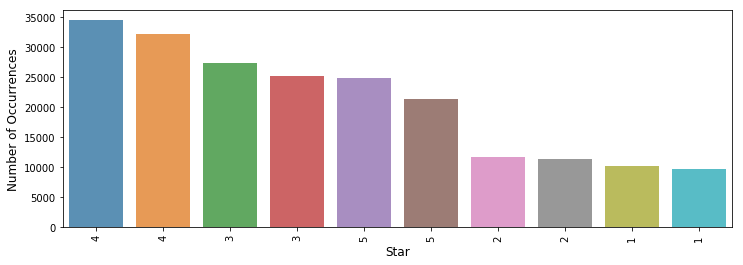

In [10]:
plot_star_count(df['star'].value_counts())

### 2.7 整理评分数据

In [11]:
num_str_list = ['0', '1', '2', '3', '4', '5']
for i in range(len(num_str_list)):
    df.loc[df['star'] == num_str_list[i], 'star'] = i

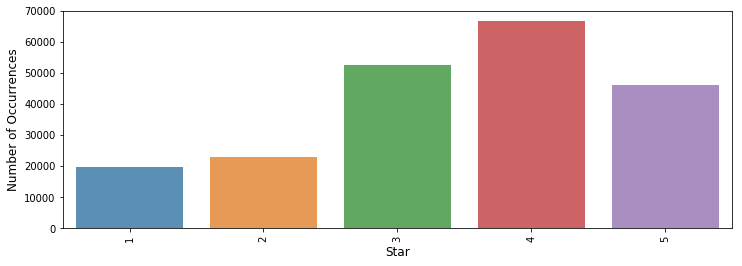

In [12]:
plot_star_count(df['star'].value_counts())

### 2.8 数据平衡

In [13]:
star_counts = df['star'].value_counts()

In [14]:
size_per_class = star_counts.min()

In [68]:
serie2 = make_banlance_samples(df, 2, size_per_class)

In [69]:
serie2.shape

(19873,)

In [72]:
serie2.index = range(serie2.shape[0])

In [73]:
serie2.head()

0    前半段 剥茧抽丝 看上去 倒 是 不雷人 黄子 韬 表现 也 还行 但是 结局 还是 很 中...
1             缺 了 阿兰 里克 曼 这样 的 亮点 反派 这片 的 文戏 简直 是 一泡 乌
2            除了 堆积 现代 特技 故事 干瘪 演员 能力 有限 男主是 韩国 还是 中国 呀
3                                   老套 的 电影 怎么 会 是 年 的
4                          跟 九层 妖塔 没 区别 舒淇 港腔 太重 容易 出戏
Name: word_tokens, dtype: object

In [34]:
star_class_list = df['star'].unique().tolist()
star_class_list.sort()

In [35]:
print(star_class_list)

[1, 2, 3, 4, 5]


In [83]:
star = 'star_{}'.format(2)
print(star)

star_2


In [99]:
def make_banlance_samples(df, star_class, size_per_class):
    tmp_ser = df['word_tokens'][df['star'] == star_class]
    if tmp_ser.shape[0] > size_per_class:
        tmp_ser = tmp_ser.sample(n=size_per_class, random_state=42)
    tmp_ser.index = range(tmp_ser.shape[0])
    #tmp_ser.name = 'star_{}'.format(star_class)
    return tmp_ser

In [100]:
def merge_df(df, star_class_list, size_per_class):
    new_df = pd.DataFrame()
    for star_class in star_class_list:
        star_ser = make_banlance_samples(df, star_class, size_per_class)
        #star = 'star_{}'.format(star_class)
        new_df = pd.concat([new_df, pd.DataFrame(star_ser)], axis=1, ignore_index=True)
        #new_df = new_df.append(make_banlance_samples(df, star_class, size_per_class))
    
    return new_df

In [101]:
new_df = merge_df(df, star_class_list, size_per_class)
new_df.columns=['star_1', 'star_2', 'star_3', 'star_4','star_5']

In [102]:
new_df.head()

,star_1,star_2,star_3,star_4,star_5
0,吴京 意淫 到 了 脑残 的 地步 看 了 恶心 想 吐,前半段 剥茧抽丝 看上去 倒 是 不雷人 黄子 韬 表现 也 还行 但是 结局 还是 很 中...,场景 文艺 爱情 文艺,机油 搞笑 不能 因为 烂 名字 错过 的,美好 的 小事
1,中二得 很,缺 了 阿兰 里克 曼 这样 的 亮点 反派 这片 的 文戏 简直 是 一泡 乌,我 觉得 这种 咨询 顾问 不 可能 有效,对于 这样 的 经典 我 在 抱 有 充分 尊重 的 同时 也 习惯于 带 着 质疑 去 欣...,反过来 的 非常 突然
2,犯 我 中华 者 虽远必 诛 吴京 比 这句 话 还要 意淫 一百倍,除了 堆积 现代 特技 故事 干瘪 演员 能力 有限 男主是 韩国 还是 中国 呀,看到 后面 才 说出 这 其实 是 旅游 广告片 么 里面 的 主旨 是 有 的 略 矫情 ...,重温 原来 第一站 那么 好看 场面 精彩 流畅 大气 情绪 渲染 到位 配乐 十分 燃 剧...,大师
3,吴京 的 冷峰 在 这部 里 即 像 成龙 又 像杰 森斯坦 森但 体制 外 的 同 类型 ...,老套 的 电影 怎么 会 是 年 的,大 隐隐 于市,女人 也 可以 不 依靠 任何人 而活 的 很 好 当然 这 取决于 她 自身 对 爱情 友...,李安 把 中西文化 结合 的 恰到好处 做足 了 细节 相比之下 前期 作品 更 打动 人
4,犯 我 中华 者 虽远必 诛 是 有 多 无脑 才 信 这句 话,跟 九层 妖塔 没 区别 舒淇 港腔 太重 容易 出戏,我 好像 不是 很 喜欢 这个 姑娘 啊,制作 非常 好 不过 剧情 太 日本,感动 落泪


In [103]:
new_df.to_csv('douban.csv',index=False)

## 3. 从词向量到句向量

### 3.1 加载训练好的word2vec 模型

In [104]:
from gensim.models import Word2Vec
zh_wiki_word2vec_model = Word2Vec.load('../lesson04/cbow_word2vec.model')

In [105]:
zh_wiki_word2vec_model.vector_size

200

 ### 3.2 sentence embedding
 
 A Simple but Tough-to-Beat Baseline for Sentence Embeddings
 ref： https://github.com/PrincetonML/SIF

In [106]:
def get_word_frequency(word, model):
    try:
        freq = model.wv.vocab[word].count
    except KeyError:
        freq = 1.0
    return freq

In [107]:
def get_word_vector(word, model):
    try:
        vec = model[word]
    except KeyError:
        vec = np.zeros(model.vector_size)
    return vec

In [108]:
import numpy as np

In [109]:
from sklearn.decomposition import PCA

In [110]:
def sentence_to_vec(sentence_list, word2vec_model, a=1e-3):
    
    embedding_size = word2vec_model.vector_size
    sentence_set = []

    for sentence in sentence_list:
        vs = np.zeros(embedding_size, dtype=np.float32)  # add all word2vec values into one vector for the sentence
        word_tokens = sentence.split()
        sentence_length = len(word_tokens)

        for word in word_tokens:
            a_value = a / (a + get_word_frequency(word, word2vec_model))  # smooth inverse frequency, SIF
            vs = np.add(vs, np.multiply(a_value, get_word_vector(word, word2vec_model)))  # vs += sif * word_vector

        vs = np.divide(vs, sentence_length)  # weighted average
        sentence_set.append(vs)  # add to our existing re-calculated set of sentences

    
    # calculate PCA of this sentence set
    pca = PCA(n_components=embedding_size)
    pca.fit(np.array(sentence_set))
    u = pca.components_[0]  # the PCA vector
    u = np.multiply(u, np.transpose(u))  # u x uT

    # pad the vector?  (occurs if we have less sentences than embeddings_size)
    if len(u) < embedding_size:
        for i in range(embedding_size - len(u)):
            u = np.append(u, 0)  # add needed extension for multiplication below

    # resulting sentence vectors, vs = vs -u x uT x vs
    sentence_vecs = []
    for vs in sentence_set:
        sub = np.multiply(u, vs)
        sentence_vecs.append(np.subtract(vs, sub).astype(np.float32))

    return sentence_vecs

In [111]:
star_names = ['star_1', 'star_2', 'star_3', 'star_4','star_5']

In [115]:
from six.moves import cPickle as pickle

for star_name in star_names:
    sentence_vectors = sentence_to_vec(new_df[star_name], zh_wiki_word2vec_model)
    dataset = np.array(sentence_vectors)
    set_filename = star_name + '.pickle'
    try:
        with open(set_filename, 'wb') as f:
            pickle.dump(dataset, f, pickle.HIGHEST_PROTOCOL)
    except Exception as e:
        print('Unable to save data to', set_filename, ':', e)

D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This is separate from the ipykernel package so we can avoid doing imports until
D:\Program\Anaconda3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: Call to deprecated `__getitem__` (Method will be removed in 4.0.0, use self.wv.__getitem__() instead).
  This

##  4.Train neaual network model

## 4.1 按比例70 15 15 划分训练集，验证集，测试集

In [116]:
star_names = ['star_1', 'star_2', 'star_3', 'star_4','star_5']
pickle_files = []
for star_name in star_names:
    pickle_files.append(star_name + '.pickle')

In [122]:
for pickle_file in pickle_files:
    with open(pickle_file, 'rb') as pk_f:
        dat = pickle.load(pk_f)
    print('number of pictures in {} = '.format(pickle_file), dat.shape)

number of pictures in star_1.pickle =  (19873, 200)
number of pictures in star_2.pickle =  (19873, 200)
number of pictures in star_3.pickle =  (19873, 200)
number of pictures in star_4.pickle =  (19873, 200)
number of pictures in star_5.pickle =  (19873, 200)


In [134]:
def make_arrays(nb_rows, embedding_size):
    dataset = np.ndarray((nb_rows, embedding_size), dtype=np.float32)
    labels = np.ndarray(nb_rows, dtype=np.int32)
    return dataset, labels

def merge_datasets(pickle_files, embedding_size, sample_size_per_class, train_ratio, valid_ratio, test_ratio):
    
    train_size_per_class = int(sample_size_per_class * train_ratio)
    valid_size_per_class = int(sample_size_per_class * valid_ratio)
    test_size_per_class  = int(sample_size_per_class * test_ratio)

    num_classes = len(pickle_files)
    train_dataset, train_labels = make_arrays(train_size_per_class*num_classes, embedding_size)
    valid_dataset, valid_labels = make_arrays(valid_size_per_class*num_classes, embedding_size)
    test_dataset,   test_labels = make_arrays(test_size_per_class*num_classes, embedding_size)
    
    start_train, start_valid, start_test = 0, 0, 0
    end_train, end_valid, end_test = train_size_per_class, valid_size_per_class, test_size_per_class
    end_train_valid = train_size_per_class + valid_size_per_class
    end_last = train_size_per_class + valid_size_per_class + test_size_per_class

    for label, pickle_file in enumerate(pickle_files):
        try:
            with open(pickle_file, 'rb') as f:
                letter_set = pickle.load(f)
                # let's shuffle the letters to have random validation and training set
                np.random.shuffle(letter_set)

                train_letter = letter_set[:train_size_per_class, :]
                train_dataset[start_train:end_train, :] = train_letter
                train_labels[start_train:end_train] = label
                start_train += train_size_per_class
                end_train += train_size_per_class

                valid_letter = letter_set[train_size_per_class:end_train_valid, :]
                valid_dataset[start_valid:end_valid, :] = valid_letter
                valid_labels[start_valid:end_valid] = label
                start_valid += valid_size_per_class
                end_valid += valid_size_per_class

                test_letter = letter_set[end_train_valid:end_last, :]
                test_dataset[start_test:end_test, :] = test_letter
                test_labels[start_test:end_test] = label
                start_test += test_size_per_class
                end_test += test_size_per_class

        except Exception as e:
            print('Unable to process data from', pickle_file, ':', e)
            raise
    
    return train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels

In [135]:
train_dataset, train_labels, valid_dataset, valid_labels, test_dataset, test_labels = merge_datasets(
    pickle_files, 200, 19873, 0.8, 0.1, 0.1)

print('Training:', train_dataset.shape, train_labels.shape)
print('Validation:', valid_dataset.shape, valid_labels.shape)
print('Testing:', test_dataset.shape, test_labels.shape)

Training: (79490, 200) (79490,)
Validation: (9935, 200) (9935,)
Testing: (9935, 200) (9935,)


In [138]:
num_labels = 5

def reformat(labels):
    # Map 0 to [1.0, 0.0, 0.0 ...], 1 to [0.0, 1.0, 0.0 ...]
    labels = (np.arange(num_labels) == labels[:,None]).astype(np.float32)
    return labels
train_labels = reformat(train_labels)
valid_labels = reformat(valid_labels)
test_labels = reformat(test_labels)
print('Training set', train_dataset.shape, train_labels.shape)
print('Validation set', valid_dataset.shape, valid_labels.shape)
print('Test set', test_dataset.shape, test_labels.shape)

Training set (79490, 200) (79490, 5)
Validation set (9935, 200) (9935, 5)
Test set (9935, 200) (9935, 5)


### 4.2 构建tf graph

In [139]:
embedding_size = zh_wiki_word2vec_model.vector_size
num_labels = 5

In [140]:
import tensorflow as tf

In [141]:

num_nodes= 1024
batch_size = 128

graph = tf.Graph()
with graph.as_default():

    # Input data. For the training data, we use a placeholder that will be fed
    # at run time with a training minibatch.
    tf_train_dataset = tf.placeholder(tf.float32, shape=(batch_size, embedding_size))
    tf_train_labels = tf.placeholder(tf.float32, shape=(batch_size, num_labels))
    tf_valid_dataset = tf.constant(valid_dataset)
    tf_test_dataset = tf.constant(test_dataset)

    # Variables.
    weights_1 = tf.Variable(tf.truncated_normal([embedding_size, num_nodes]))
    biases_1 = tf.Variable(tf.zeros([num_nodes]))
    weights_2 = tf.Variable(tf.truncated_normal([num_nodes, num_labels]))
    biases_2 = tf.Variable(tf.zeros([num_labels]))

    # Training computation.
    logits_1 = tf.matmul(tf_train_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    loss = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(labels=tf_train_labels, logits=logits_2))

    # Optimizer.
    optimizer = tf.train.GradientDescentOptimizer(0.5).minimize(loss)

    # Predictions for the training
    train_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for validation 
    logits_1 = tf.matmul(tf_valid_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    valid_prediction = tf.nn.softmax(logits_2)
    
    # Predictions for test
    logits_1 = tf.matmul(tf_test_dataset, weights_1) + biases_1
    relu_layer= tf.nn.relu(logits_1)
    logits_2 = tf.matmul(relu_layer, weights_2) + biases_2
    
    test_prediction = tf.nn.softmax(logits_2)

In [142]:
num_steps = 10001

def accuracy(predictions, labels):
    return (100.0 * np.sum(np.argmax(predictions, 1) == np.argmax(labels, 1))
          / predictions.shape[0])

with tf.Session(graph=graph) as session:
    tf.global_variables_initializer().run()
    print("Initialized")
    for step in range(num_steps):
        # Pick an offset within the training data, which has been randomized.
        # Note: we could use better randomization across epochs.
        offset = (step * batch_size) % (train_labels.shape[0] - batch_size)
        # Generate a minibatch.
        batch_data = train_dataset[offset:(offset + batch_size), :]
        batch_labels = train_labels[offset:(offset + batch_size), :]
        # Prepare a dictionary telling the session where to feed the minibatch.
        # The key of the dictionary is the placeholder node of the graph to be fed,
        # and the value is the numpy array to feed to it.
        feed_dict = {tf_train_dataset : batch_data, tf_train_labels : batch_labels}
        _, l, predictions = session.run([optimizer, loss, train_prediction], feed_dict=feed_dict)
        if (step % 500 == 0):
            print("Minibatch loss at step {}: {}".format(step, l))
            print("Minibatch accuracy: {:.1f}%".format(accuracy(predictions, batch_labels)))
            print("Validation accuracy: {:.1f}%".format(accuracy(valid_prediction.eval(), valid_labels)))
    print("Test accuracy: {:.1f}%".format(accuracy(test_prediction.eval(), test_labels)))

Initialized
Minibatch loss at step 0: 1.6092209815979004
Minibatch accuracy: 86.7%
Validation accuracy: 20.0%
Minibatch loss at step 500: 0.8494643568992615
Minibatch accuracy: 100.0%
Validation accuracy: 20.0%
Minibatch loss at step 1000: 0.3035784661769867
Minibatch accuracy: 100.0%
Validation accuracy: 20.0%
Minibatch loss at step 1500: 0.28874245285987854
Minibatch accuracy: 100.0%
Validation accuracy: 20.0%
Minibatch loss at step 2000: 0.1566796749830246
Minibatch accuracy: 100.0%
Validation accuracy: 20.0%
Minibatch loss at step 2500: 0.11684799939393997
Minibatch accuracy: 100.0%
Validation accuracy: 20.0%
Minibatch loss at step 3000: 0.08830983191728592
Minibatch accuracy: 100.0%
Validation accuracy: 20.0%
Minibatch loss at step 3500: 0.0707460269331932
Minibatch accuracy: 100.0%
Validation accuracy: 20.0%
Minibatch loss at step 4000: 0.05901327729225159
Minibatch accuracy: 100.0%
Validation accuracy: 20.0%
Minibatch loss at step 4500: 0.05064419284462929
Minibatch accuracy: 10